In [1]:
#@title Import Libraries
from google.colab import drive,files
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata
import pandas as pd
import seaborn as sns
sns.set_theme(style="white")
plt.figure(figsize=(50, 20))

from sklearn.model_selection import train_test_split
from sklearn import metrics,linear_model
from sklearn.metrics import mean_squared_error,roc_curve, confusion_matrix
import altair as alt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

<Figure size 5000x2000 with 0 Axes>

In [3]:
#@title Generate Random Log Normal Distribution Data, asssuming treatment to have 10% lift

# Step 1: Define the parameters
population_arpu = 50 #average revenue per user/customer
sample_size = 10000

# Step 2: Define the log-normal distribution parameters
control_mu = np.log(population_arpu)  # Log of the mean
treatment_mu = np.log(population_arpu*1.1) # 10% higher ARPU for treatment group
sigma = 0.5  # Standard deviation (this can be adjusted based on desired spread)

# Step 3: Generate log-normal distribution data
control = np.random.lognormal(control_mu, sigma, sample_size)
treatment = np.random.lognormal(treatment_mu, sigma, sample_size)
df_1=pd.DataFrame({'variant':"Control",'data':control})
df_2=pd.DataFrame({'variant':"Treatment",'data':treatment})
df=pd.concat([df_1,df_2])
df.head()

,variant,data
0,Control,40.071880
1,Control,32.665687
2,Control,31.375136
3,Control,17.296980
4,Control,60.725195


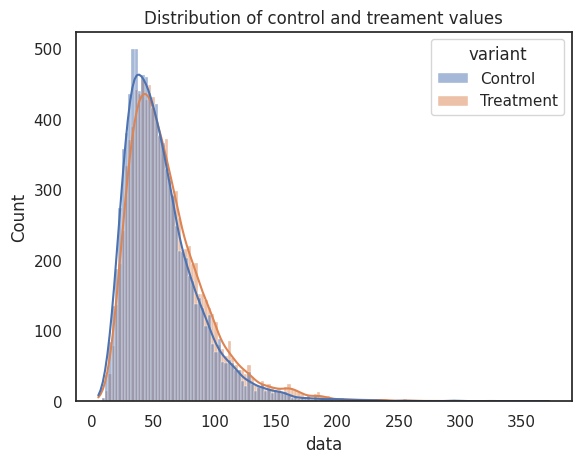

In [4]:
sns.histplot(data=df,x="data",hue="variant",kde=True,alpha=0.5);
plt.title('Distribution of control and treament values');

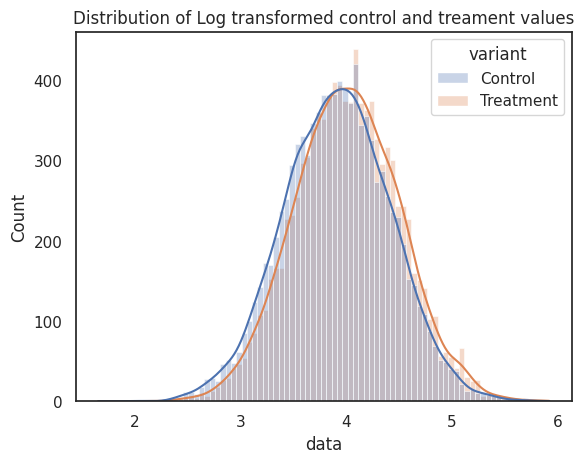

In [5]:
sns.histplot(data=df,x=np.log(df['data']),hue="variant",kde=True,alpha=0.3);
plt.title('Distribution of Log transformed control and treament values');

<ipython-input-73-860700a0ac96>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mean_df = pd.concat([mean_df, pd.DataFrame({'sample_size': sample_size[j], 'mean_diff': [mean_diff]})], ignore_index=True)


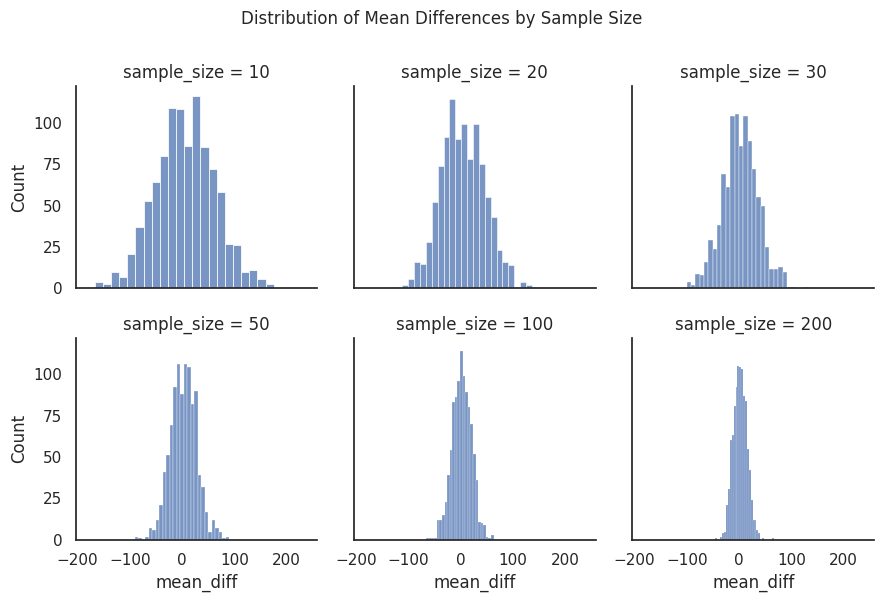

In [73]:
sample_size=[10,20,30,50,100,200]
mean_df=pd.DataFrame(columns=['sample_size','mean_diff'])
for i in range(1000):
  for j in range(len(sample_size)):
    control_sample_mean=np.random.choice(control, size=sample_size[j], replace=False).mean()
    treatment_sample_mean=np.random.choice(treatment, size=sample_size[j], replace=False).mean()
    mean_diff=(treatment_sample_mean-control_sample_mean)
    mean_df = pd.concat([mean_df, pd.DataFrame({'sample_size': sample_size[j], 'mean_diff': [mean_diff]})], ignore_index=True)

#Plot Distributions
g=sns.FacetGrid(mean_df,col="sample_size",col_wrap=3)
g.map_dataframe(sns.histplot, x="mean_diff")
g.fig.suptitle("Distribution of Mean Differences by Sample Size", fontsize=12, y=1)
g.fig.tight_layout()
plt.show()

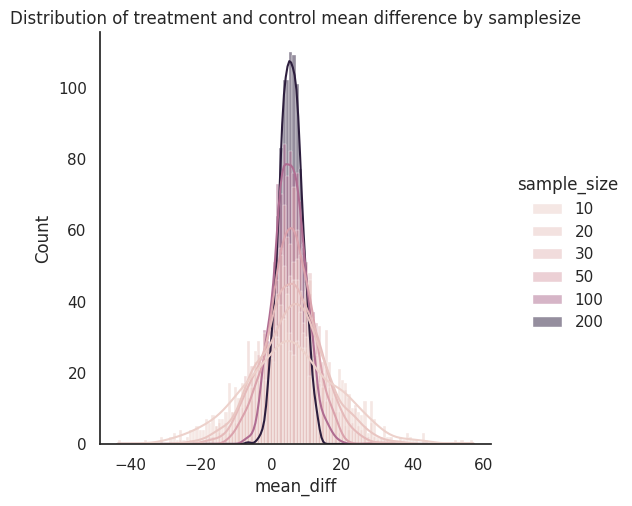

In [ ]:
sns.displot(data=mean_df,x="mean_diff",hue="sample_size",kde=True);
plt.title('Distribution of treatment and control mean difference by samplesize');

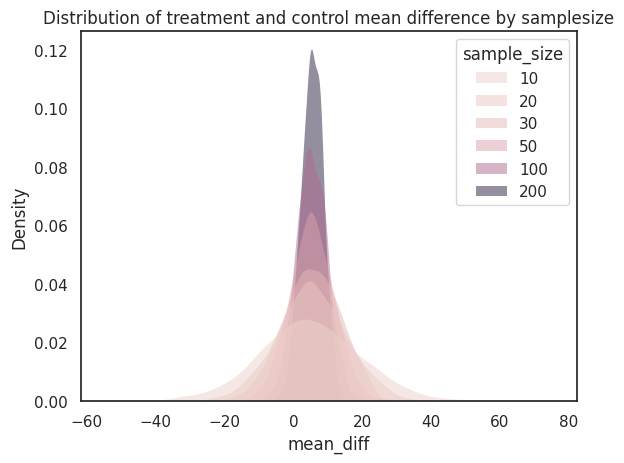

In [7]:
sns.kdeplot(
   data=mean_df, x="mean_diff", hue="sample_size",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0,
)
plt.title('Distribution of treatment and control mean difference by samplesize');

In [9]:
#@title A-A test on control
aa_test_df=pd.DataFrame(columns=['iteration','p_value','absolute_lift','pct_lift'])
for i in range(1000):
  control_sample_1=np.random.choice(control, size=200, replace=False)
  control_sample_2=np.random.choice(control, size=200, replace=False)
  t_stat, p_value = stats.ttest_ind(control_sample_1, control_sample_2)
  absolute_lift=(control_sample_1.mean()-control_sample_2.mean())
  pct_lift=absolute_lift/control_sample_2.mean()
  data = np.column_stack((i+1, p_value,absolute_lift,pct_lift))
  df_temp = pd.DataFrame(data, columns=['iteration','p_value','absolute_lift','pct_lift'])
  aa_test_df = pd.concat([aa_test_df, df_temp], ignore_index=True)


<ipython-input-9-8b541acaf895>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aa_test_df = pd.concat([aa_test_df, df_temp], ignore_index=True)


In [10]:
aa_test_df.head()

,iteration,p_value,absolute_lift,pct_lift
0,1.0,0.933101,-0.264626,-0.004730
1,2.0,0.646939,-1.314092,-0.022981
2,3.0,0.584245,1.565798,0.028577
3,4.0,0.720399,-1.210144,-0.020165
4,5.0,0.993118,-0.025989,-0.000457


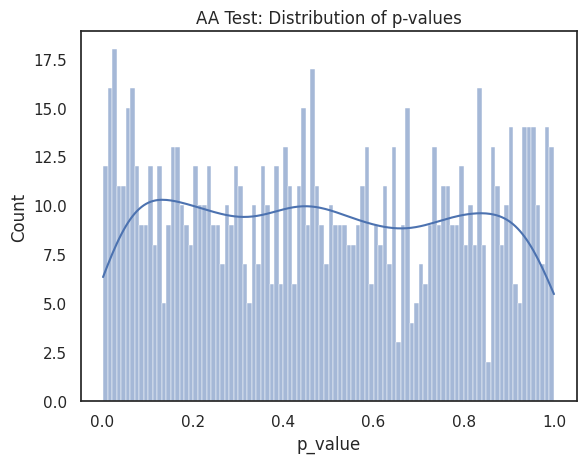

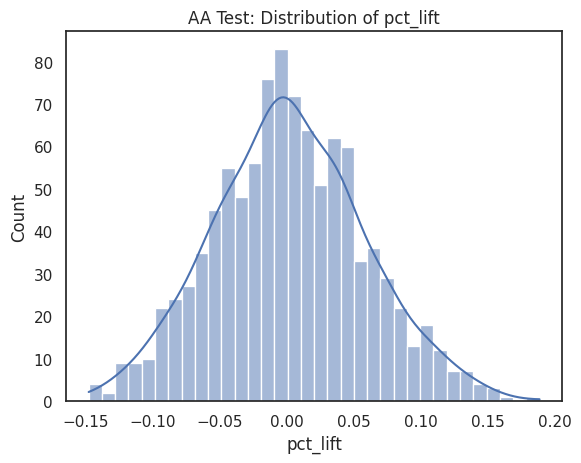

In [11]:
sns.histplot(data=aa_test_df,x="p_value",binwidth=0.01,kde=True)
plt.title('AA Test: Distribution of p-values')
plt.show();
sns.histplot(data=aa_test_df,x="pct_lift",binwidth=0.01,kde=True)
plt.title('AA Test: Distribution of pct_lift')
plt.show();

In [12]:
#@title T test
t_stat, p_value = stats.ttest_ind(treatment, control)
absolute_lift=(treatment.mean()-control.mean())
pct_lift=absolute_lift/control.mean()
print("Absolute lift:", absolute_lift)
print("Percentage lift:", pct_lift*100.00)
print("T-statistic:", t_stat)
print("P-value:", p_value)

Absolute lift: 5.39304325731257
Percentage lift: 9.466314063079247
T-statistic: 11.942573677610856
P-value: 9.176259251317255e-33


In [13]:
#@title A-B test iterations
aa_test_df=pd.DataFrame(columns=['iteration','p_value','absolute_lift','pct_lift'])
for i in range(1000):
  control_sample=np.random.choice(control, size=200, replace=False)
  treatment_sample=np.random.choice(treatment, size=200, replace=False)
  t_stat, p_value = stats.ttest_ind(control_sample, treatment_sample)
  absolute_lift=(treatment_sample.mean()-control_sample.mean())
  pct_lift=absolute_lift/control_sample.mean()
  data = np.column_stack((i+1, p_value,absolute_lift,pct_lift))
  df_temp = pd.DataFrame(data, columns=['iteration','p_value','absolute_lift','pct_lift'])
  aa_test_df = pd.concat([aa_test_df, df_temp], ignore_index=True)


<ipython-input-13-774171d1e2d8>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aa_test_df = pd.concat([aa_test_df, df_temp], ignore_index=True)


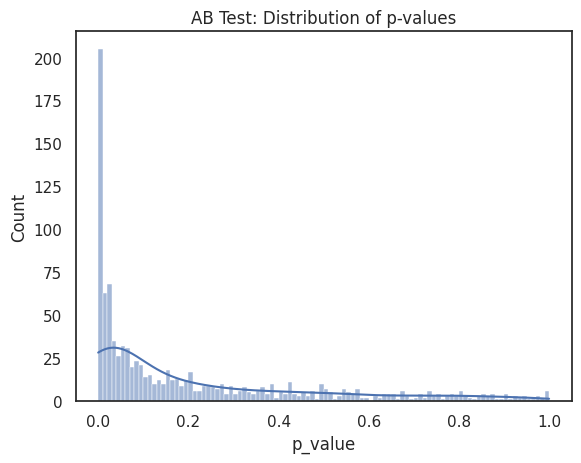

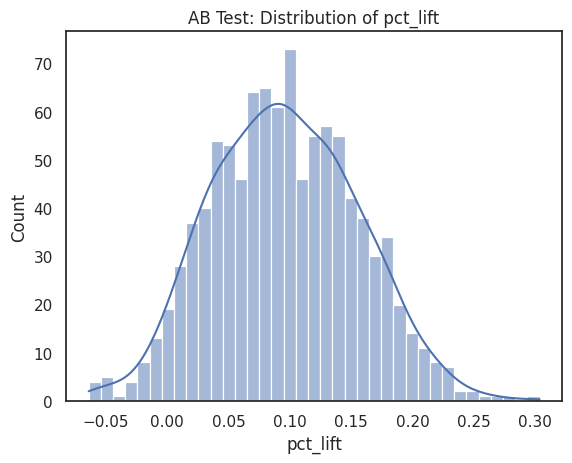

In [14]:
sns.histplot(data=aa_test_df,x="p_value",binwidth=0.01,kde=True)
plt.title('AB Test: Distribution of p-values')
plt.show();
sns.histplot(data=aa_test_df,x="pct_lift",binwidth=0.01,kde=True)
plt.title('AB Test: Distribution of pct_lift')
plt.show();

In [15]:
#@title AB testing real world example
# original file here- https://drive.google.com/file/d/1rhdz8zfaulnJrCmzVWpXZHC2HMTSU136/view?usp=drive_link
drive.mount('/content/drive')
ab_data=pd.read_csv('/content/drive/MyDrive/Study/ab_testing/ab_test_data_updated.csv')
ab_data.head()

Mounted at /content/drive


,variant,customer_id,exposure_date,conversion_flag,order_value
0,control,C_0,2024-01-07,True,125.830677
1,control,C_1,2024-01-20,True,161.167232
2,control,C_2,2024-01-15,True,53.233289
3,control,C_3,2024-01-11,True,515.790528
4,control,C_4,2024-01-08,True,11.496341


In [16]:
ab_data.info()
ab_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   variant          200000 non-null  object 
 1   customer_id      200000 non-null  object 
 2   exposure_date    200000 non-null  object 
 3   conversion_flag  200000 non-null  bool   
 4   order_value      200000 non-null  float64
dtypes: bool(1), float64(1), object(3)
memory usage: 6.3+ MB


,variant,customer_id,exposure_date,conversion_flag,order_value
0,control,C_0,2024-01-07,True,125.830677
1,control,C_1,2024-01-20,True,161.167232
2,control,C_2,2024-01-15,True,53.233289
3,control,C_3,2024-01-11,True,515.790528
4,control,C_4,2024-01-08,True,11.496341


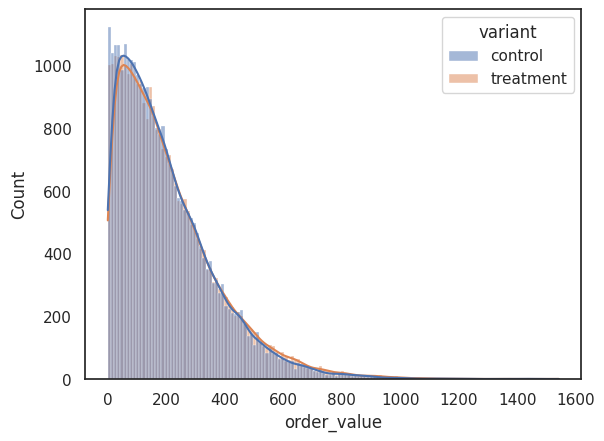

In [17]:
#@title AOV per customer is north star metric.
sns.histplot(data=ab_data[ab_data['conversion_flag']==True], x='order_value',hue='variant',kde=True);

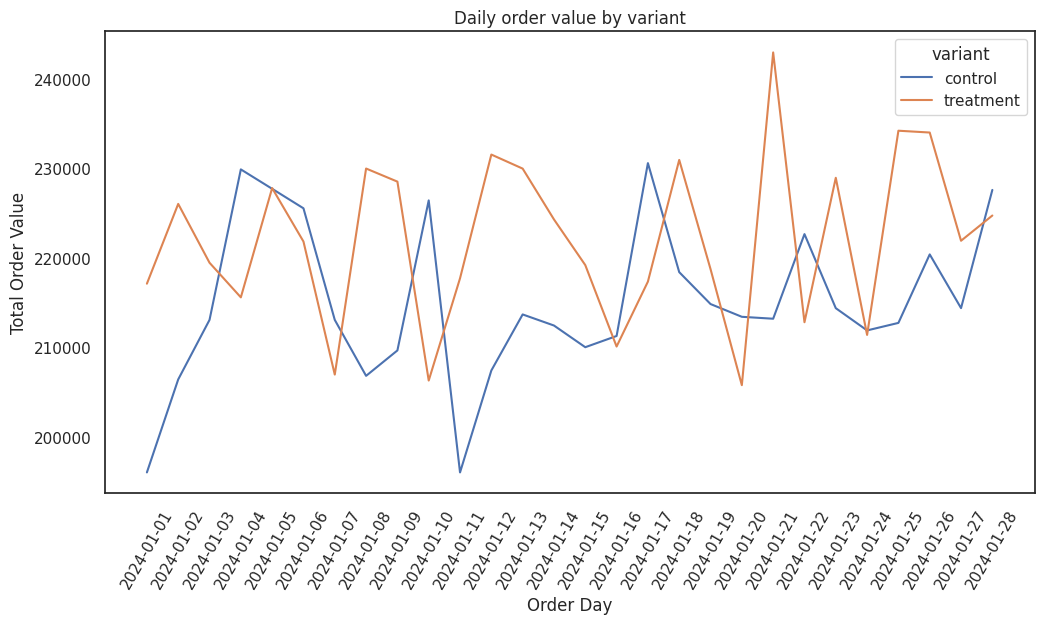

In [18]:
plt.figure(figsize=(12, 6))
(
    ab_data
      .groupby(['exposure_date','variant'])
      .agg({'order_value':'sum'})
      .reset_index()
      .pipe(sns.lineplot,x='exposure_date',y='order_value',hue='variant')
      .set(title='Daily order value by variant', xlabel="Order Day", ylabel="Total Order Value")
)
plt.xticks(rotation=60)
# plt.suptitle("Split by variants")
plt.show();

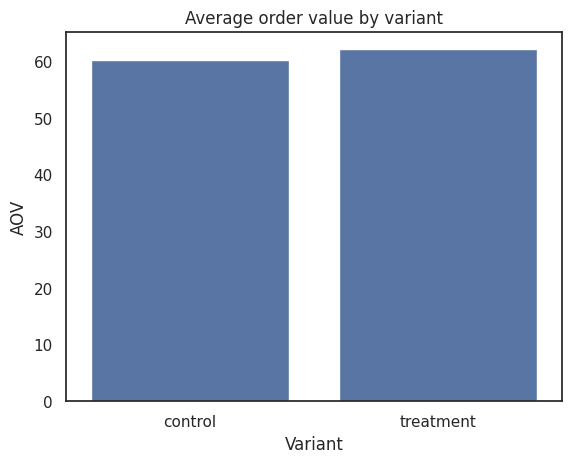

In [19]:
(
    ab_data
      .groupby('variant')
      .agg({'order_value':'mean'})
      .reset_index()
      .pipe(sns.barplot,x='variant',y='order_value')
      .set(title='Average order value by variant', xlabel="Variant", ylabel="AOV")
)
plt.show();

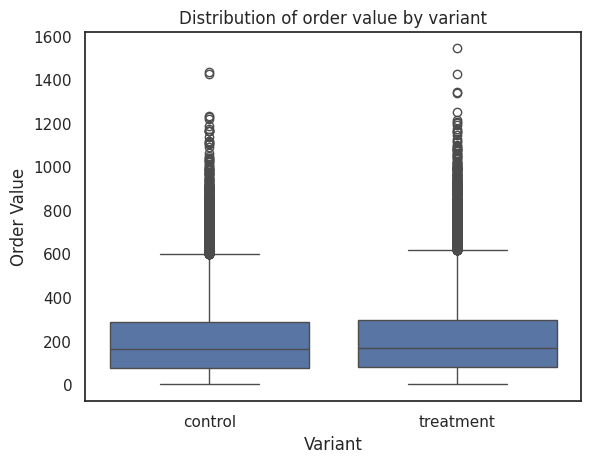

In [20]:
(
    ab_data[ab_data['conversion_flag']==True]
      .pipe(sns.boxplot,x='variant',y='order_value')
      .set(title='Distribution of order value by variant', xlabel="Variant", ylabel="Order Value")
);

In [25]:
#@title Assuming conversion rate is the North Star metric

# control has higher conversion rate than treatment
(
    ab_data
      .groupby('variant')
      .agg(total_observations=('conversion_flag','count'),
           conversion_rate=('conversion_flag','mean'),
           total_conversion=('conversion_flag','sum'),
           total_revenue=('order_value','sum'))
      .reset_index()
)


,variant,total_observations,conversion_rate,total_conversion,total_revenue
0,control,100000,0.29935,29935,6.020041e+06
1,treatment,100000,0.29781,29781,6.216333e+06


In [66]:
# Perform test of proportions (for checking conversion rate)
from statsmodels.stats.proportion import proportions_ztest
control_converted=29935
treatment_converted=29781
n_control=100000
n_treatment=100000
control_conversion_rate=control_converted/n_control
treatment_conversion_rate=treatment_converted/n_treatment
counts = np.array([control_converted, treatment_converted])
nobs = np.array([n_control, n_treatment])
z_stat, p_value = proportions_ztest(counts, nobs)
print(f"Control Conversion Rate: {control_conversion_rate:.2%}")
print(f"Treatment Converion Rate: {treatment_conversion_rate:.2%}")
print(f"Conversion Rate Lift Pct: {((treatment_conversion_rate/control_conversion_rate)-1):.2%}")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")


Control Conversion Rate: 29.94%
Treatment Converion Rate: 29.78%
Conversion Rate Lift Pct: -0.51%
Z-statistic: 0.7525
P-value: 0.4518


In [64]:
#@title T Test for revenue per customer
customer_aggregation=ab_data.groupby('customer_id').agg({'order_value':'sum','variant':'max'}).reset_index()
control=customer_aggregation[customer_aggregation['variant']=='control']['order_value']
treatment=customer_aggregation[customer_aggregation['variant']=='treatment']['order_value']
control_arpu=float(control.mean())
treatment_arpu=float(treatment.mean())
t_stat, p_value = stats.ttest_ind(treatment, control)

print(f"Control ARPU: {control_arpu:.3f}")
print(f"Treatment ARPU: {treatment_arpu:.3f}")
print(f"ARPU Lift: {((treatment_arpu/control_arpu-1)):.2%}")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Control ARPU: 60.200
Treatment ARPU: 62.163
ARPU Lift: 3.26%
Z-statistic: 0.7525
P-value: 0.0008


ARPU Lift: 3.26 %


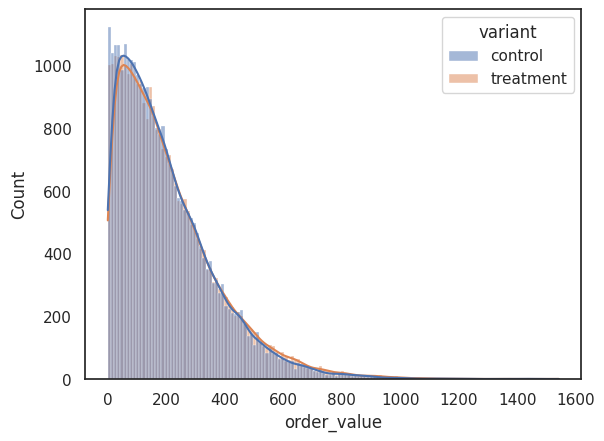

In [36]:
sns.histplot(data=customer_aggregation[customer_aggregation['order_value']>0], x='order_value', hue='variant',kde=True)
plt.show()